In [73]:
import numpy as np
import scipy as sp
from scipy.linalg import hankel, block_diag
import cvxpy as cp
import matplotlib.pyplot as plt

In [74]:
def generate_prbs_like_signal(array1, array2, NUM_STEPS):
    tuple_list = []
    for i in range(NUM_STEPS):
        
        # Pick random elements from each array
        step_length = np.random.choice(array1)
        step_value = np.random.choice(array2)
        tuple_list.append((step_length, step_value))


    system_input = (np.concatenate([np.full(length, value) for length, value in tuple_list])).reshape(1,-1)

    return system_input


def simulating_system(initial_cond, system_input, system_parameters):
    
    states = np.zeros(shape = (2, np.size(system_input, 1) + 1))
    # initial states
    states[:, [0]] = initial_cond
    
    for i in range(np.size(system_input, 1)):
        
        mumax = system_parameters[0]
        Ks = system_parameters[1]
        Y = system_parameters[2]
        S0 = system_parameters[3]
        
        X = states[0, i]
        S = states[1, i]
    
        q0 = system_input[0, i]
        
        states[0, i+1] = Ts * ((mumax*S*X/(Ks+S)) - q0*X) + X
        states[1, i+1] = Ts * (-((mumax/Y)*S*X/(Ks+S)) + q0*(S0-S) ) + S

    return states




def solve_data_driven_mpc(dict_matrix,u_ini, y_ini, Q, R, r, N, 
                             u_lower_bound, u_upper_bound, y_lower_bound, y_upper_bound,
                             lambda_g ):
    
    # Define and solve the CVXPY problem.
    u = cp.Variable(N)
    y = cp.Variable(N)
    g = cp.Variable((np.size(dict_matrix, 1), 1))

    # define the block diag matrices
    block_diag_Q = block_diag(*([Q] * N))
    block_diag_R = block_diag(*([R] * N))


    # Ensure proper reshaping for stacking
    e = cp.vstack([
        u_ini.reshape(-1, 1),   
        y_ini.reshape(-1, 1),   
        cp.reshape(u, (-1, 1)), 
        cp.reshape(y, (-1, 1)) 
    ])
    constraints = [dict_matrix @ g <= e]


    # Identity matrix of size N
    I_N = np.eye(N)

    # Construct A matrix for the constraints
    A = np.block([
        [-I_N, np.zeros((N, N))],  
        [I_N, np.zeros((N, N))],   
        [np.zeros((N, N)), -I_N],  
        [np.zeros((N, N)), I_N] 
    ])

    # Construct the right-hand side vector
    b = np.hstack([
        np.ones(N) * -1 * u_lower_bound,  
        np.ones(N) * u_upper_bound,  
        np.ones(N) * -1 * y_lower_bound, 
        np.ones(N) * y_upper_bound 
    ])

    # Stack variables
    v = cp.reshape(cp.vstack([u, y]), (-1,1))

    # # Define constraints using the A matrix
    constraints += [A @ v<=b]

    objective = cp.Minimize(cp.quad_form(u, block_diag_R) + cp.quad_form(y-r, block_diag_Q) + lambda_g * cp.norm(g))

    prob = cp.Problem(objective, constraints)
    prob.solve()

    return prob, u, y, g




In [75]:
# disctitization time
Ts = 0.1
# initial states
initial_cond = np.array([[0.5],[0]])
# system nominal parameter
system_parameters = (np.array([0.4, 2, 0.6, 0.4]))


step_length = [3]
steps = np.arange(0, 2, 0.1)
zeros = np.zeros(shape=(10))
steps_level = np.concatenate((steps, zeros))
NUM_STEPS = 200
system_input = generate_prbs_like_signal(step_length, steps_level, NUM_STEPS)


# system_input_2 = np.random.rand(1, 100) * 2

# system_input = np.concatenate((system_input_1, system_input_2), axis=1)

states  = simulating_system(initial_cond, system_input, system_parameters)
system_output = states[[1],:]


print(system_input.shape, system_output.shape)


(1, 600) (1, 601)


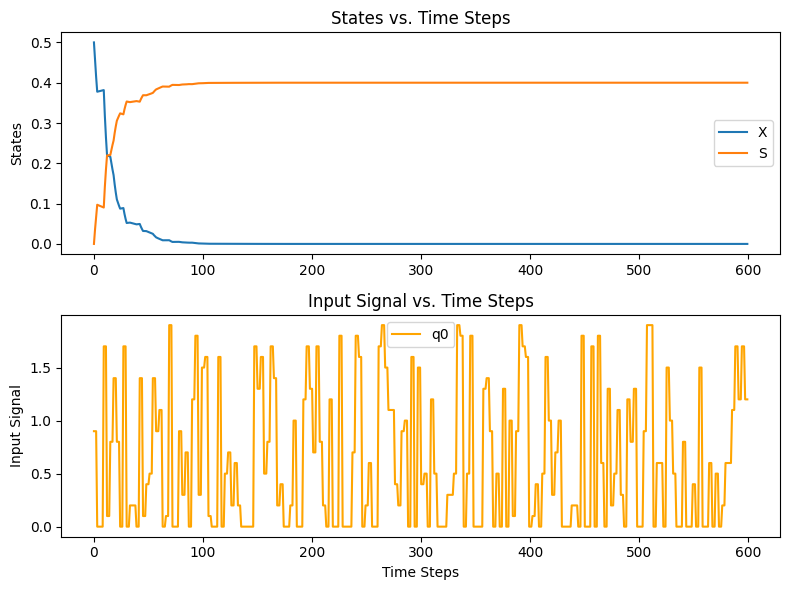

In [76]:

# Time steps
SIM_TIME = np.size(system_input, 1)
time_steps = np.arange(SIM_TIME)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# First subplot: states vs. time steps
axes[0].plot(time_steps, states[0, :-1], label="X")
axes[0].plot(time_steps, states[1, :-1], label="S")
axes[0].set_title("States vs. Time Steps")
axes[0].set_ylabel("States")
axes[0].legend()


# Second subplot: input signal vs. time steps
axes[1].plot(time_steps, system_input[0, :], label="q0", color="orange")
axes[1].set_title("Input Signal vs. Time Steps")
axes[1].set_xlabel("Time Steps")
axes[1].set_ylabel("Input Signal")
axes[1].legend()


# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [77]:
"""   
We are ready to apply the data driven control to the Pekilo process!
"""

'   \nWe are ready to apply the data driven control to the Pekilo process!\n'

In [78]:
Tini = 4
N = 20
T = np.size(system_input, 1)
L = Tini + N

hankel_input = hankel(system_input)[0:L, 0:T-L]
hankel_output = hankel(system_output)[0:L, 0:T-L]

Up = hankel_input[0:Tini, :]
Uf = hankel_input[Tini:,:]

Yp = hankel_output[0:Tini, :]
Yf = hankel_output[Tini:,:]

dict_matrix = np.concatenate((Up, Yp, Uf, Yf), axis=0)

print(Up.shape, Uf.shape, Yp.shape, Yf.shape, dict_matrix.shape)

(4, 576) (20, 576) (4, 576) (20, 576) (48, 576)


In [79]:
# initial states
# initial_cond = np.array([[0.1],[0]])
# system nominal parameter
# system_parameters = (np.array([0.4, 2, 0.6, 1]))
# reference signal
r = np.ones((N)) * 0.5

u_upper_bound = 1
u_lower_bound = 0

y_upper_bound = 1
y_lower_bound = 0

# cost function matrices 
Q = np.array([1000])
R = np.array([0.001])

lambda_g = 0.1


# Experiment time: how many time steps you want to apply the controller
exp_time = 800

# how many steps we want to take from u optimal 
s = 1

# call the system to get yini
u_ini = np.ones((1, Tini)) * 0
states  = simulating_system(initial_cond, u_ini, system_parameters)
# we the final states
final_states = states[:,[-1]]
# we get the y and record
y_ini = states[[1],:-1]
print(final_states.shape)


# save them for later on
u_trajectory = u_ini
y_trajectory = y_ini

(2, 1)


In [80]:

for i in range(exp_time):
    # solve the CVX optimization to get u, and y 
    prob, u, y, g = solve_data_driven_mpc(dict_matrix,u_ini, y_ini, Q, R, r, N, 
                             u_lower_bound, u_upper_bound, y_lower_bound, y_upper_bound,
                             lambda_g )

    u_to_apply = (u.value[0:s]).reshape(1, -1)

    # print(u_to_apply.shape)
    # pick the first entry from u 
    # apply it to the system 
    states  = simulating_system(final_states, u_to_apply, system_parameters)
    
    # we the final states
    final_states = states[:,[-1]]
    out_put = states[[1],0:s]
    
    u_concat = np.concatenate((u_ini, u_to_apply), axis=1)
    y_concat = np.concatenate((y_ini, out_put), axis=1)

    # update u_ini and y_ini and do it again!!!
    u_ini = u_concat[[0],-Tini:]
    y_ini = y_concat[[0],-Tini:]
    
    u_trajectory = np.concatenate((u_trajectory, u_to_apply), axis=1)
    y_trajectory = np.concatenate((y_trajectory, out_put), axis=1)

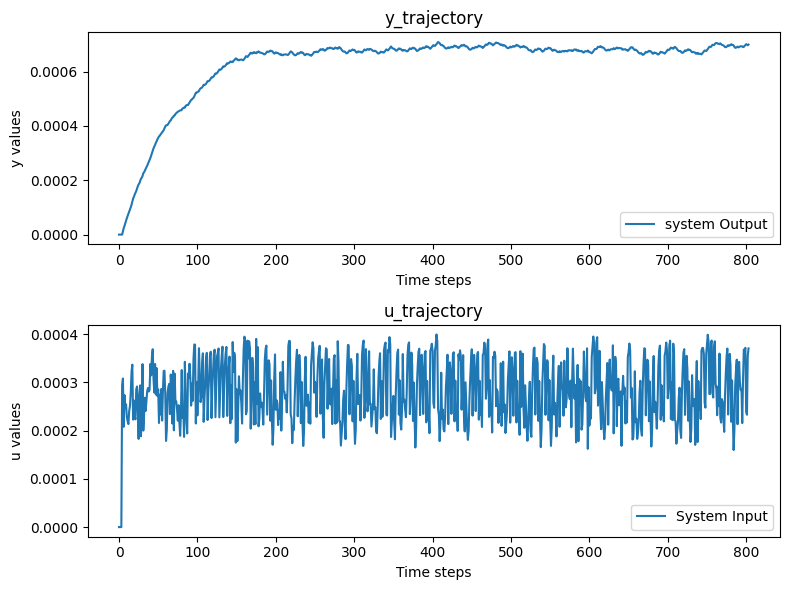

In [81]:
# Create the figure and the 2x1 subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot y_trajectory on the top subplot (axs[0])
axs[0].plot(y_trajectory.T, label="system Output")
axs[0].set_title("y_trajectory")
axs[0].set_xlabel("Time steps")
axs[0].set_ylabel("y values")
axs[0].legend()

# Plot u_trajectory on the bottom subplot (axs[1])
axs[1].plot(u_trajectory.T, label="System Input")
axs[1].set_title("u_trajectory")
axs[1].set_xlabel("Time steps")
axs[1].set_ylabel("u values")

axs[1].legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()
